<a href="https://colab.research.google.com/github/chew2116/20242R0136COSE47402/blob/master/3_Object_Detection_and_Multiple_Object_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlvlab/COSE474_2024/blob/main/3_Object_Detection_and_Multiple_Object_Tracking.ipynb)

# **Lab Session 3. Object Detection and Multiple Object Tracking**

**Contents**
1. Preparation
2. Object Detection
3. Multiple Object Tracking

**Reference**
*   End-to-End Object Detection with Transformers (DETR): https://github.com/facebookresearch/detr
*   Multi-Object Tracking by Associating Every Detection Box (ByteTrack): https://github.com/ifzhang/ByteTrack





## **I. Preparation**
* In this section, you will mount your Google Drive and create extra space for this tutorial.













In [7]:
from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
import os

# Set the root directory
root = "/content/drive/"  # Set according to Google Drive path (usually /content/drive/ in Colab)

# Create COSE474 directory
cose474_path = os.path.join(root, "My Drive/Colab Notebooks/COSE474")
os.makedirs(cose474_path, exist_ok=True)

# Create Object_Detection directory
od_path = os.path.join(cose474_path, "Object_Detection")
os.makedirs(od_path, exist_ok=True)

# Navigate to Object_Detection directory
%cd "{od_path}"

/content/drive/My Drive/Colab Notebooks/COSE474/Object_Detection





### **1. Install dependencies**








In [9]:
# Install Dependencies
!pip3 uninstall torch torchvision torchaudio -y
!pip3 install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0
!pip3 install cython
!pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip3 install cython_bbox
!pip3 install matplotlib
!pip3 install lapx

# Git clone: ByteTrack (ECCV 2022)
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack

# == Install dependencies ==
# == Update 'requirements.txt' Before Installation ==
with open("requirements.txt", "r") as f:
    lines = f.readlines()

# == Modify 'requirements.txt' ==
with open("requirements.txt", "w") as f:
    for line in lines:
        # Remove 'lap' and any old 'onnx' version if they exist
        if 'lap' not in line.strip() and 'onnx' not in line.strip():
            f.write(line)

    # Add the new ONNX-related dependencies
    f.write("\nonnx==1.13.0\n")
    f.write("onnxruntime==1.13.1\n")
    f.write("onnx-simplifier==0.3.5\n")

# == Install Dependencies from Updated 'requirements.txt' ==
!pip3 install -r requirements.txt

# == Install ByteTrack ==
!python3 setup.py develop

Found existing installation: torch 1.13.0
Uninstalling torch-1.13.0:
  Successfully uninstalled torch-1.13.0
Found existing installation: torchvision 0.14.0
Uninstalling torchvision-0.14.0:
  Successfully uninstalled torchvision-0.14.0
Found existing installation: torchaudio 0.13.0
Uninstalling torchaudio-0.13.0:
  Successfully uninstalled torchaudio-0.13.0
  Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl.metadata (23 kB)
  Using cached torchvision-0.14.0-cp310-cp310-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-0.13.0-cp310-cp310-manylinux1_x86_64.whl.metadata (1.0 kB)
Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl (890.1 MB)
Using cached torchvision-0.14.0-cp310-cp310-manylinux1_x86_64.whl (24.3 MB)
Using cached torchaudio-0.13.0-cp310-cp310-manylinux1_x86_64.whl (4.2 MB)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-l77c8fm4
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/




### **2. Download data**


* Download the image and video data for the practical exercise.








In [10]:
%cd "{od_path}"

# make directory for input data
DATA_PATH = "data"
%mkdir "{DATA_PATH}"

# download sample image, video data
!wget -P "{DATA_PATH}" https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.png
!wget -P "{DATA_PATH}" https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.mp4

# make directory for output data
OUTPUT_PATH = "output"
%mkdir "{OUTPUT_PATH}"

/content/drive/My Drive/Colab Notebooks/COSE474/Object_Detection
mkdir: cannot create directory ‘data’: File exists
--2024-11-07 02:32:01--  https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8784826 (8.4M) [application/octet-stream]
Saving to: ‘data/dog.png.1’

dog.png.1           100%[===================>]   8.38M  24.4MB/s    in 0.3s    

2024-11-07 02:32:01 (24.4 MB/s) - ‘data/dog.png.1’ saved [8784826/8784826]

--2024-11-07 02:32:01--  https://raw.githubusercontent.com/mlvlab/COSE474_2024/main/sample_data/dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.g

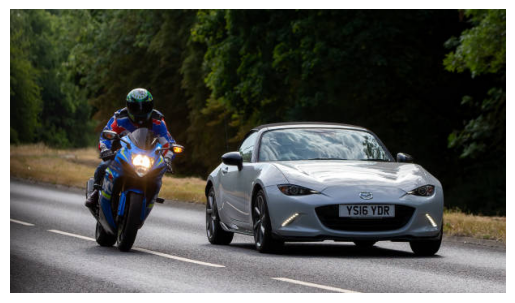

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
img_ex_path = "data/car.jpg"
img_ex = Image.open(img_ex_path).convert('RGB')
plt.imshow(img_ex)
plt.axis('off')
plt.show()





## **II. Object Detection**

* In this section, we will perform object detection on image using DETR *(ECCV20)*.









### **0. Setup**

In [13]:
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

### **1. Pre & Post Processing**

In [14]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# rescale bounding boxes from normalized coordinates to the original image size.
def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    scale_factors = torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device=device)
    b = b * scale_factors
    return b


### **2. Load Pre-trained DETR**

In [15]:
class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [16]:
# a function to load the DETR model with pretrained weights and set it to evaluation mode.
def load_detr_model(num_classes=91,
                    pretrained_url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth'):

    # Set the device (use CUDA if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the DETR model
    model = DETR(num_classes=num_classes)

    # Load pretrained weights
    state_dict = torch.hub.load_state_dict_from_url(
        url=pretrained_url, map_location=device, check_hash=True
    )

    # Load the state dictionary into the model
    model.load_state_dict(state_dict)

    # Set the model to evaluation mode
    model.eval()

    # Move the model to the specified device
    model.to(device)

    return model

detr = load_detr_model()

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth


  0%|          | 0.00/79.3M [00:00<?, ?B/s]

In [17]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

### **3. Inference & Visualization**

In [34]:
# detect objects in an image using the DETR model.
def detect(im, model, transform):
    # Set the device (use CUDA if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the input image to the same device as the model
    img = transform(im).unsqueeze(0).to(device)

    # Ensure the image size does not exceed 1600x1600
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, \
        'The model only supports images up to 1600 pixels on each side.'

    # Propagate through the model
    outputs = model(img)

    # Keep only predictions with confidence > 0.8
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # Convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)

    return probas[keep], bboxes_scaled

scores, boxes = detect(img_ex, detr, transform)

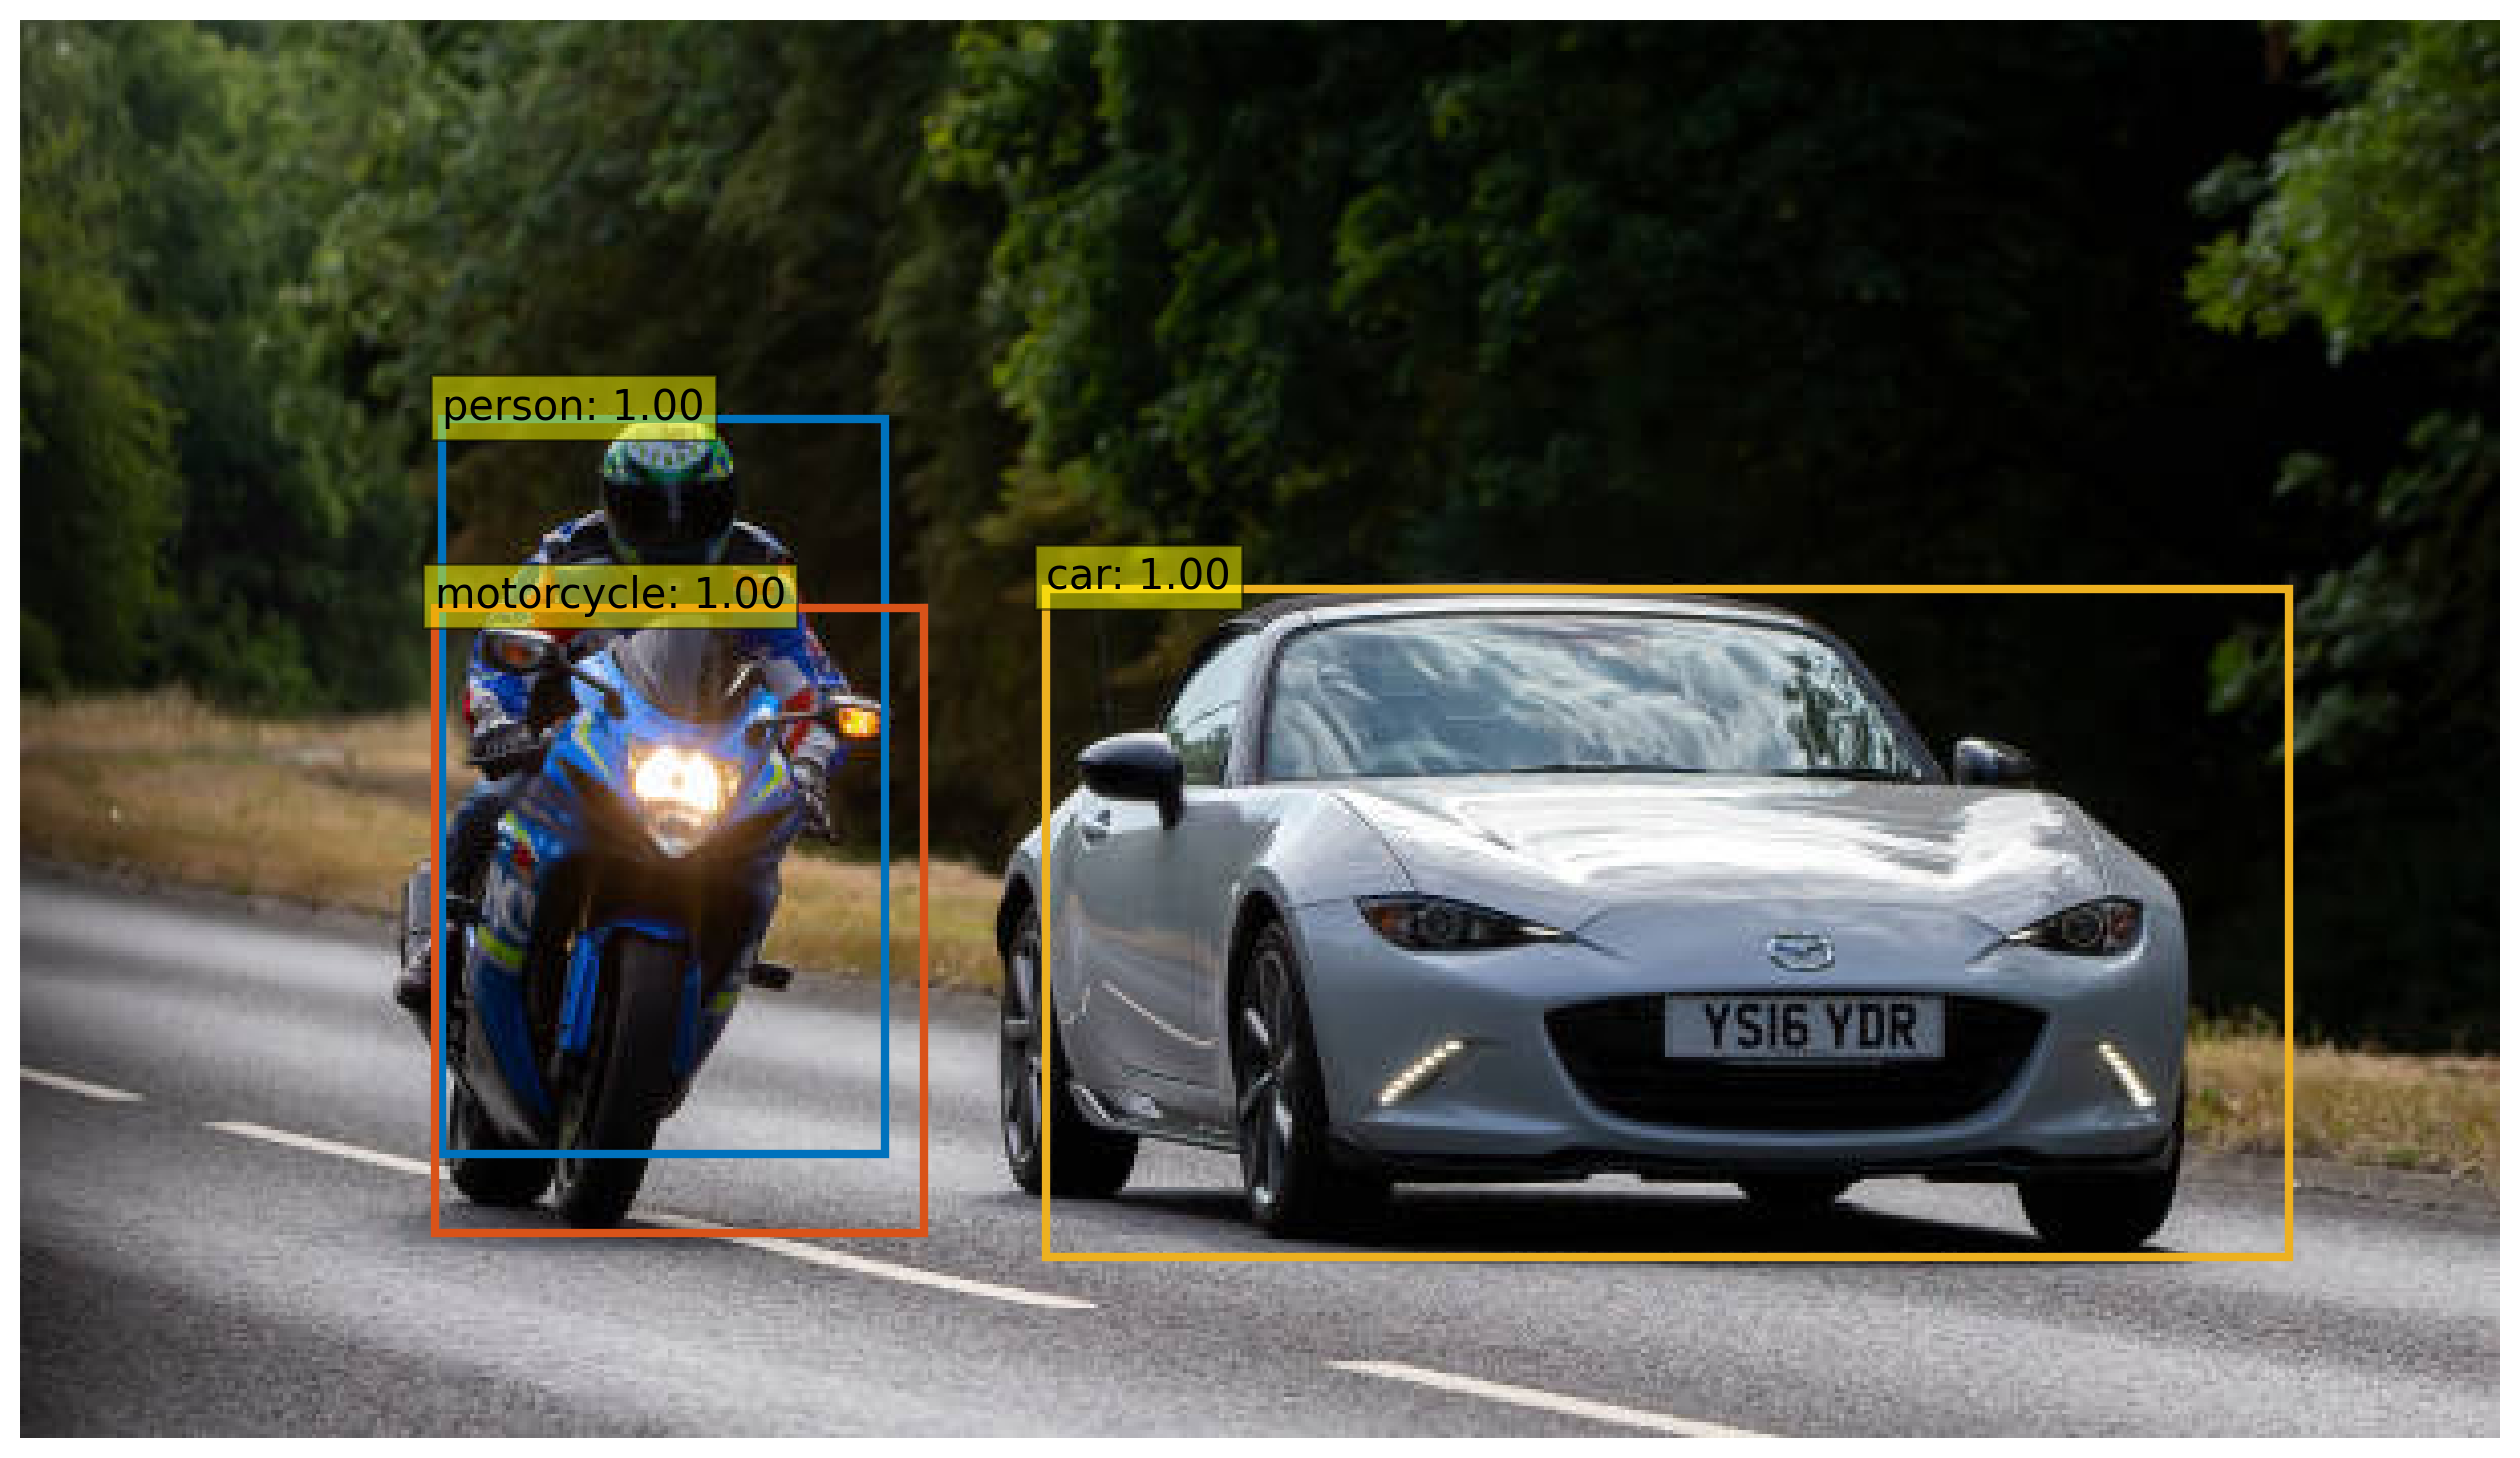

In [35]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(img_ex, scores, boxes)




## **III. Multiple Object Tracking**

* In this section, we will perform multiple object tracking on video using ByteTrack *(ECCV22)*.



### **0. Setup**

In [36]:
%cd ByteTrack
from pathlib import Path
from loguru import logger
import cv2
import argparse
import sys
import torch
from torchvision.transforms import functional as F
from yolox.tracker.byte_tracker import BYTETracker
from yolox.tracking_utils.timer import Timer
import requests
import numpy as np
np.float = float
import matplotlib.pyplot as plt
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

/content/drive/My Drive/Colab Notebooks/COSE474/Object_Detection/ByteTrack


In [37]:
# ByteTrack argument parser
def make_parser():
    parser = argparse.ArgumentParser("ByteTrack")
    parser.add_argument("--demo", default="image", help="demo type, e.g., image, video, and webcam")
    parser.add_argument("-expn", "--experiment-name", type=str, default=None)
    parser.add_argument("-n", "--name", type=str, default=None, help="model name")

    # Video input and output paths
    parser.add_argument("--video_path", default="", help="path to input video")
    parser.add_argument("--output_path", default="", help="path to save output video")

    parser.add_argument("--camid", type=int, default=0, help="webcam demo camera ID")
    parser.add_argument("--save_result", action="store_true", help="save the inference result")

    # Experiment file and checkpoint
    parser.add_argument("-f", "--exp_file", type=str, help="experiment description file")
    parser.add_argument("-c", "--ckpt", type=str, help="checkpoint for evaluation")
    parser.add_argument("--device", default="gpu", type=str, help="device (cpu or gpu)")

    # Detection and tracking thresholds
    parser.add_argument("--detect_thresh", type=float, default=0.8, help="detection confidence threshold")
    parser.add_argument("--track_thresh", type=float, default=0.9, help="tracking confidence threshold")
    parser.add_argument("--track_buffer", type=int, default=100, help="frames to keep lost tracks")
    parser.add_argument("--match_thresh", type=float, default=0.9, help="matching threshold")

    # Additional settings
    parser.add_argument("--aspect_ratio_thresh", type=float, default=1.6, help="aspect ratio threshold")
    parser.add_argument("--min_box_area", type=float, default=1, help="filter tiny boxes")
    parser.add_argument("--mot20", action="store_true", help="test on MOT20 dataset")

    parser.add_argument("--fps", type=int, default=30, help="frame rate (fps)")
    parser.add_argument("--fp16", action="store_true", help="enable mixed precision")
    parser.add_argument("--fuse", action="store_true", help="fuse convolution and batch norm")
    parser.add_argument("--trt", action="store_true", help="use TensorRT for inference")

    return parser

In [38]:
# For color visualization
COCO_CATEGORIES = [
    {"color": [], "isthing": 0, "id": 0, "name": "N/A"},
    {"color": [220, 20, 60], "isthing": 1, "id": 1, "name": "person"},
    {"color": [119, 11, 32], "isthing": 1, "id": 2, "name": "bicycle"},
    {"color": [0, 0, 142], "isthing": 1, "id": 3, "name": "car"},
    {"color": [0, 0, 230], "isthing": 1, "id": 4, "name": "motorcycle"},
    {"color": [106, 0, 228], "isthing": 1, "id": 5, "name": "airplane"},
    {"color": [0, 60, 100], "isthing": 1, "id": 6, "name": "bus"},
    {"color": [0, 80, 100], "isthing": 1, "id": 7, "name": "train"},
    {"color": [0, 0, 70], "isthing": 1, "id": 8, "name": "truck"},
    {"color": [0, 0, 192], "isthing": 1, "id": 9, "name": "boat"},
    {"color": [250, 170, 30], "isthing": 1, "id": 10, "name": "traffic light"},
    {"color": [100, 170, 30], "isthing": 1, "id": 11, "name": "fire hydrant"},
    {"color": [], "isthing": 0, "id": 12, "name": "N/A"},
    {"color": [220, 220, 0], "isthing": 1, "id": 13, "name": "stop sign"},
    {"color": [175, 116, 175], "isthing": 1, "id": 14, "name": "parking meter"},
    {"color": [250, 0, 30], "isthing": 1, "id": 15, "name": "bench"},
    {"color": [165, 11, 42], "isthing": 1, "id": 16, "name": "bird"},
    {"color": [222, 26, 252], "isthing": 1, "id": 17, "name": "cat"},
    {"color": [31, 33, 115], "isthing": 1, "id": 18, "name": "dog"},
    {"color": [82, 22, 115], "isthing": 1, "id": 19, "name": "horse"},
    {"color": [0, 82, 0], "isthing": 1, "id": 20, "name": "sheep"},
    {"color": [120, 166, 157], "isthing": 1, "id": 21, "name": "cow"},
    {"color": [110, 76, 0], "isthing": 1, "id": 22, "name": "elephant"},
    {"color": [174, 57, 255], "isthing": 1, "id": 23, "name": "bear"},
    {"color": [199, 100, 0], "isthing": 1, "id": 24, "name": "zebra"},
    {"color": [72, 0, 118], "isthing": 1, "id": 25, "name": "giraffe"},
    {"color": [], "isthing": 0, "id": 26, "name": "N/A"},
    {"color": [255, 179, 240], "isthing": 1, "id": 27, "name": "backpack"},
    {"color": [0, 125, 92], "isthing": 1, "id": 28, "name": "umbrella"},
    {"color": [], "isthing": 0, "id": 29, "name": "N/A"},
    {"color": [], "isthing": 0, "id": 30, "name": "N/A"},
    {"color": [209, 0, 151], "isthing": 1, "id": 31, "name": "handbag"},
    {"color": [188, 208, 182], "isthing": 1, "id": 32, "name": "tie"},
    {"color": [0, 220, 176], "isthing": 1, "id": 33, "name": "suitcase"},
    {"color": [255, 99, 164], "isthing": 1, "id": 34, "name": "frisbee"},
    {"color": [92, 0, 73], "isthing": 1, "id": 35, "name": "skis"},
    {"color": [133, 129, 255], "isthing": 1, "id": 36, "name": "snowboard"},
    {"color": [78, 180, 255], "isthing": 1, "id": 37, "name": "sports ball"},
    {"color": [0, 228, 0], "isthing": 1, "id": 38, "name": "kite"},
    {"color": [174, 255, 243], "isthing": 1, "id": 39, "name": "baseball bat"},
    {"color": [45, 89, 255], "isthing": 1, "id": 40, "name": "baseball glove"},
    {"color": [134, 134, 103], "isthing": 1, "id": 41, "name": "skateboard"},
    {"color": [145, 148, 174], "isthing": 1, "id": 42, "name": "surfboard"},
    {"color": [255, 208, 186], "isthing": 1, "id": 43, "name": "tennis racket"},
    {"color": [197, 226, 255], "isthing": 1, "id": 44, "name": "bottle"},
    {"color": [], "isthing": 0, "id": 45, "name": "N/A"},
    {"color": [171, 134, 1], "isthing": 1, "id": 46, "name": "wine glass"},
    {"color": [109, 63, 54], "isthing": 1, "id": 47, "name": "cup"},
    {"color": [207, 138, 255], "isthing": 1, "id": 48, "name": "fork"},
    {"color": [151, 0, 95], "isthing": 1, "id": 49, "name": "knife"},
    {"color": [9, 80, 61], "isthing": 1, "id": 50, "name": "spoon"},
    {"color": [84, 105, 51], "isthing": 1, "id": 51, "name": "bowl"},
    {"color": [74, 65, 105], "isthing": 1, "id": 52, "name": "banana"},
    {"color": [166, 196, 102], "isthing": 1, "id": 53, "name": "apple"},
    {"color": [208, 195, 210], "isthing": 1, "id": 54, "name": "sandwich"},
    {"color": [255, 109, 65], "isthing": 1, "id": 55, "name": "orange"},
    {"color": [0, 143, 149], "isthing": 1, "id": 56, "name": "broccoli"},
    {"color": [179, 0, 194], "isthing": 1, "id": 57, "name": "carrot"},
    {"color": [209, 99, 106], "isthing": 1, "id": 58, "name": "hot dog"},
    {"color": [5, 121, 0], "isthing": 1, "id": 59, "name": "pizza"},
    {"color": [0, 165, 120], "isthing": 1, "id": 60, "name": "donut"},
    {"color": [147, 186, 208], "isthing": 1, "id": 61, "name": "cake"},
    {"color": [153, 69, 1], "isthing": 1, "id": 62, "name": "chair"},
    {"color": [3, 95, 161], "isthing": 1, "id": 63, "name": "couch"},
    {"color": [163, 255, 0], "isthing": 1, "id": 64, "name": "potted plant"},
    {"color": [119, 0, 170], "isthing": 1, "id": 65, "name": "bed"},
    {"color": [], "isthing": 0, "id": 66, "name": "N/A"},
    {"color": [0, 182, 199], "isthing": 1, "id": 67, "name": "dining table"},
    {"color": [], "isthing": 0, "id": 68, "name": "N/A"},
    {"color": [], "isthing": 0, "id": 69, "name": "N/A"},
    {"color": [227, 255, 205], "isthing": 1, "id": 70, "name": "toilet"},
    {"color": [], "isthing": 0, "id": 71, "name": "N/A"},
    {"color": [183, 130, 88], "isthing": 1, "id": 72, "name": "tv"},
    {"color": [95, 32, 0], "isthing": 1, "id": 73, "name": "laptop"},
    {"color": [130, 114, 135], "isthing": 1, "id": 74, "name": "mouse"},
    {"color": [110, 129, 133], "isthing": 1, "id": 75, "name": "remote"},
    {"color": [166, 74, 118], "isthing": 1, "id": 76, "name": "keyboard"},
    {"color": [219, 142, 185], "isthing": 1, "id": 77, "name": "cell phone"},
    {"color": [79, 210, 114], "isthing": 1, "id": 78, "name": "microwave"},
    {"color": [178, 90, 62], "isthing": 1, "id": 79, "name": "oven"},
    {"color": [65, 70, 15], "isthing": 1, "id": 80, "name": "toaster"},
    {"color": [127, 167, 115], "isthing": 1, "id": 81, "name": "sink"},
    {"color": [59, 105, 106], "isthing": 1, "id": 82, "name": "refrigerator"},
    {"color": [], "isthing": 0, "id": 83, "name": "N/A"},
    {"color": [142, 108, 45], "isthing": 1, "id": 84, "name": "book"},
    {"color": [196, 172, 0], "isthing": 1, "id": 85, "name": "clock"},
    {"color": [95, 54, 80], "isthing": 1, "id": 86, "name": "vase"},
    {"color": [128, 76, 255], "isthing": 1, "id": 87, "name": "scissors"},
    {"color": [201, 57, 1], "isthing": 1, "id": 88, "name": "teddy bear"},
    {"color": [246, 0, 122], "isthing": 1, "id": 89, "name": "hair drier"},
    {"color": [191, 162, 208], "isthing": 1, "id": 90, "name": "toothbrush"},
]

def _get_coco_instances_meta():
    thing_ids = [k["id"] for k in COCO_CATEGORIES if k["isthing"] == 1]

    thing_dataset_id_to_contiguous_id = {k: i for i, k in enumerate(thing_ids)}
    thing_classes = [k["name"] for k in COCO_CATEGORIES if k["isthing"] == 1]
    thing_colors = [k["color"] for k in COCO_CATEGORIES if k["isthing"] == 1]
    coco_classes = [k["name"] for k in COCO_CATEGORIES]

    return {
        "thing_dataset_id_to_contiguous_id": thing_dataset_id_to_contiguous_id,
        "thing_classes": thing_classes,
        "thing_colors": thing_colors,
        "coco_classes": coco_classes,
    }

### **1. Pre & Post Processing**

In [39]:
# Convert (cx, cy, w, h) -> (xmin, ymin, xmax, ymax)
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)  # Unbind the center coordinates and dimensions
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]  # Calculate corner coordinates
    return torch.stack(b, dim=1)

# Rescale bounding boxes to match the original image size
def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size  # Original image width and height
    b = box_cxcywh_to_xyxy(out_bbox)  # Convert bounding boxes to corner coordinates
    return b * torch.tensor([img_w, img_h, img_w, img_h], device=out_bbox.device)

# Run DETR detection on a single frame
def detect_with_detr(confidence, img_pil, model, device):
    img = transform(img_pil).unsqueeze(0).to(device)  # Transform and move to the device
    outputs = model(img)  # Perform inference

    # Extract probabilities and apply confidence threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]  # Class probabilities
    keep = probas.max(-1).values > confidence  # Keep predictions above confidence threshold

    # Rescale bounding boxes to original image size
    bboxes = rescale_bboxes(outputs['pred_boxes'][0, keep], img_pil.size, device)
    return probas[keep], bboxes  # Return filtered probabilities and bounding boxes

# Convert DETR outputs to BYTETracker-compatible format
def convert_to_tracker_format(probas, bboxes, device):

    # Extract scores from probas (N, 1)
    scores = probas.max(dim=-1).values.unsqueeze(1).to(device)

    # Move bboxes and detection indices to the same device
    bboxes = bboxes.to(device)
    det_idxs = torch.arange(len(bboxes), device=device).unsqueeze(1).int()

    # Concatenate tensors (all on the same device) and return (N, 6)
    return torch.cat([bboxes, scores, det_idxs], dim=1)

### **2. Inference & Visualization**

In [40]:
# Visualize detections and tracking results on the frame
def visualize_tracking(frame, probas, bboxes, online_targets, color_map):

    vis_frame = frame.copy()  # Create a copy of the frame
    for target, p, (xmin, ymin, xmax, ymax) in zip(online_targets, probas, bboxes.tolist()):
        # Display class and score
        cl = p.argmax()  # Predicted class index
        object_text = CLASSES[cl]  # Class name
        label = f"{object_text}: {p[cl]:0.2f} | ID: {target.track_id}"  # Label with class, score, and ID
        color = color_map[int(cl.item()) - 1]  # Color for the bounding box

        # Draw bounding box
        cv2.rectangle(
            vis_frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)),
            color, 2  # Thickness of 2
        )

        # Adjust text position and add background for clarity
        text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        text_x, text_y = int(xmin), int(ymin) - 10
        cv2.rectangle(vis_frame, (text_x, text_y - 10),
                      (text_x + text_size[0], text_y + text_size[1] - 5),
                      color, -1)  # Text background

        # Draw the text (in white)
        cv2.putText(vis_frame, label, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return vis_frame  # Return the visualized frame

# Process video for detection and tracking
def process_video(args, video_path, detr, color_map, device):

    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logger.error(f"Cannot open video: {video_path}")
        return

    # Configure video output settings
    output_path = args.save_path
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30  # Default to 30 FPS if unavailable
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Initialize BYTETracker
    tracker = BYTETracker(args, frame_rate=30)
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        frame_id += 1
        img_pil = F.to_pil_image(frame[..., ::-1])  # Convert BGR to RGB for PIL

        # Perform DETR detection
        probas, bboxes = detect_with_detr(args.detect_thresh, img_pil, detr, device)
        dets = convert_to_tracker_format(probas, bboxes, device)

        if dets.shape[0] == 0:
            logger.info(f"Frame {frame_id}: No detections.")
            out.write(frame)  # Save the original frame
            continue

        # Update BYTETracker with detections
        online_targets = tracker.update(
            dets, (frame.shape[0], frame.shape[1]), (frame.shape[1], frame.shape[0])
        )

        # Visualize tracking results
        vis_frame = visualize_tracking(frame, probas, bboxes, online_targets, color_map)

        # Save the visualized frame to the output video
        out.write(vis_frame)

    # Release resources
    cap.release()
    out.release()
    logger.info(f"Tracking video saved to {output_path}")
    return


In [41]:
def main(args):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize DETR model
    detr = DETR(num_classes=91)
    state_dict = torch.hub.load_state_dict_from_url(
        url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
        map_location=device, check_hash=True
    )
    detr.load_state_dict(state_dict)
    detr.to(device)
    detr.eval()

    # Define transformation
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Prepare video path and color map
    video_path = args.video_path
    color_map = _get_coco_instances_meta()['thing_colors']

    # Process the video
    process_video(args, video_path, detr, color_map, device)
    return

In [42]:
# Parse command-line arguments
args = make_parser().parse_args()

# Define video file name
VIDEO_NAME = "dog.mp4"

# Set video input and output paths
args.video_path = os.path.join(od_path, "data", VIDEO_NAME)  # Input video path
args.save_path = os.path.join(od_path, "output", VIDEO_NAME)  # Output video path

# Set detection and tracking thresholds
args.detect_thresh = 0.8  # Object detection confidence threshold
args.track_thresh = 0.8   # Object tracking confidence threshold
args.track_buffer = 500   # Frames to keep lost tracks
args.match_thresh = 0.8   # Matching threshold for tracking

# Run the main function
main(args)

2024-11-07 02:41:23.719 | INFO     | __main__:process_video:83 - Tracking video saved to /content/drive/My Drive/Colab Notebooks/COSE474/Object_Detection/output/dog.mp4
